In [5]:
# Cell 1 — Installation des dépendances
!pip install transformers datasets torchaudio

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DailyTalk/dailytalk.zip -d /content/DailyTalk

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/DailyTalk/dailytalk/data/775/1_1_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/2_0_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/2_0_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/3_1_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/3_1_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/4_0_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/4_0_d775.wav  
 extracting: /content/DailyTalk/dailytalk/data/775/5_1_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/5_1_d775.wav  
   creating: /content/DailyTalk/dailytalk/data/776/
  inflating: /content/DailyTalk/dailytalk/data/776/0_1_d776.txt  
  inflating: /content/DailyTalk/dailytalk/data/776/0_1_d776.wav  
 extracting: /content/DailyTalk/dailytalk/data/776/10_1_d776.txt  
  inflating: /content/DailyTalk/dailytalk/data/776/10_1_d776.wav  
 extractin

In [3]:
# Cell 2 — Imports & constantes
import os
import json
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Resample
from transformers import (
    AutoProcessor,
    EncodecModel,
    TrainingArguments,
    Trainer
)

# Hyper-params
SAMPLE_RATE    = 24000
MAX_LENGTH     = 123840     # ≃5 s @ 24 kHz
BATCH_SIZE     = 4
NUM_WORKERS    = 8
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DAILYTALK_ROOT = "/content/DailyTalk/dailytalk"

In [4]:
# Cell 3 — Lecture du JSON metadata → DataFrame
meta_path = os.path.join(DAILYTALK_ROOT, "metadata.json")
with open(meta_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

records = []
for dlg_id, turns in raw.items():
    for utt_id, info in turns.items():
        rec = {
            "dialogue_id":   int(dlg_id),
            "utterance_idx": int(info["utterance_idx"]),
            "speaker":       int(info["speaker"]),
            **info
        }
        records.append(rec)
meta = pd.DataFrame.from_records(records)

# Split en train / val
dialogues = sorted(meta["dialogue_id"].unique())
val_set   = set(dialogues[:128])
train_set = set(dialogues[128:])
print(f"Train dialogues: {len(train_set)}, Val dialogues: {len(val_set)}")

Train dialogues: 2413, Val dialogues: 128


In [5]:
# Cell 4 — Dataset PyTorch pour forme d’onde brute
class DailyTalkWaveDataset(Dataset):
    def __init__(self, df, subset):
        self.df        = df[df["dialogue_id"].isin(subset)].reset_index(drop=True)
        self.resampler = Resample(orig_freq=16000, new_freq=SAMPLE_RATE)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dialog = str(row["dialogue_id"])
        utt    = str(row["utterance_idx"])
        spk    = str(row["speaker"])
        fname  = f"{utt}_{spk}_d{dialog}.wav"
        path   = os.path.join(DAILYTALK_ROOT, "data", dialog, fname)

        wav, sr = torchaudio.load(path)           # (channels, n_samples)
        if sr != SAMPLE_RATE:
            wav = self.resampler(wav)
        audio = wav.mean(0)                       # (n_samples,)

        # pad / truncate
        if audio.size(0) > MAX_LENGTH:
            audio = audio[:MAX_LENGTH]
        else:
            audio = F.pad(audio, (0, MAX_LENGTH - audio.size(0)))
        return {"input_values": audio, "labels": audio}

In [6]:
def collate_fn(batch):
    # Empiler les tenseurs audio et ajouter la dimension 'channels'
    input_vals = torch.stack([ex["input_values"] for ex in batch])  # (B, L)
    labels     = torch.stack([ex["labels"]     for ex in batch])    # (B, L)
    # Encodec attend une shape (batch, channels, length)
    input_vals = input_vals.unsqueeze(1)  # (B, 1, L)
    labels     = labels.unsqueeze(1)      # (B, 1, L)
    return {"input_values": input_vals, "labels": labels}


In [7]:
# Cell 6 — Instanciation des datasets & dataloaders
train_ds = DailyTalkWaveDataset(meta, train_set)
val_ds   = DailyTalkWaveDataset(meta, val_set)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn
)
print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")

Train samples: 22553 | Val samples: 1220


In [8]:
from transformers import EncodecModel

class EncodecWithLoss(EncodecModel):
    # forward inchangé, on récupère juste le forward parent
    def forward(self, input_values, labels=None):
        return super().forward(input_values, return_dict=True)
from transformers import Trainer
import torch.nn.functional as F

class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # 1) Récupère les tenseurs
        input_vals = inputs["input_values"]   # shape (B,1,L)
        labels     = inputs["labels"]         # shape (B,1,L)
        # 2) Forward
        outputs = model(input_vals)
        # 3) Reconstruction audio
        recon = outputs.audio_values          # shape (B,1,L)
        # 4) Loss MSE
        loss = F.mse_loss(recon, labels)
        # 5) Retourne loss (et outputs si demandé)
        return (loss, outputs) if return_outputs else loss


In [9]:
!pip install transformers datasets torchaudio --upgrade

ERROR: Operation cancelled by user


In [10]:
# Cell 8 — Processor & modèle
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
model     = EncodecWithLoss.from_pretrained("facebook/encodec_24khz").to(DEVICE)
#model.gradient_checkpointing_enable()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

In [11]:
# Cell 9 — TrainingArguments & Trainer
training_args = TrainingArguments(
    output_dir="./encodec-dailytalk",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    fp16=True,
    learning_rate=1e-4,
    num_train_epochs=10,
    eval_strategy="steps", # Changed from evaluation_strategy
    eval_steps=500,
    save_steps=1000,
    logging_steps=100,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    # Remove the tokenizer argument as it's not needed for this audio task
    # tokenizer=processor.feature_extractor,
)

In [12]:
# Ajoutez ceci juste après vos imports

import torch.nn.functional as F
from transformers import Trainer

class MyTrainer(Trainer):
 def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        input_vals = inputs["input_values"]   # (B,1,L)
        labels     = inputs["labels"]         # (B,1,L)
        outputs    = model(input_vals)
        recon      = outputs.audio_values     # (B,1,L)
        loss       = F.mse_loss(recon, labels)
        return (loss, outputs) if return_outputs else loss

# Puis, dans la cellule de création du Trainer (Cell 9), remplacez Trainer par MyTrainer :

trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
)


In [13]:
# Cell 10 — Entraînement
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohamedyoussef-torgeman (mohamedyoussef-torgeman-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
500,0.003900,0.003943
1000,0.003600,0.003784
1500,0.003500,0.003679
2000,0.003500,0.003602
2500,0.003600,0.003531
3000,0.003400,0.003481
3500,0.003200,0.003445
4000,0.003300,0.003419
4500,0.003200,0.003377
5000,0.003200,0.003344


TrainOutput(global_step=28190, training_loss=0.0030564683068936157, metrics={'train_runtime': 9345.2869, 'train_samples_per_second': 24.133, 'train_steps_per_second': 3.016, 'total_flos': 2.4880282214683965e+18, 'train_loss': 0.0030564683068936157, 'epoch': 9.996630608263876})

MSE reconstruction vs original: 0.002458
— Original —


— Reconstruction —


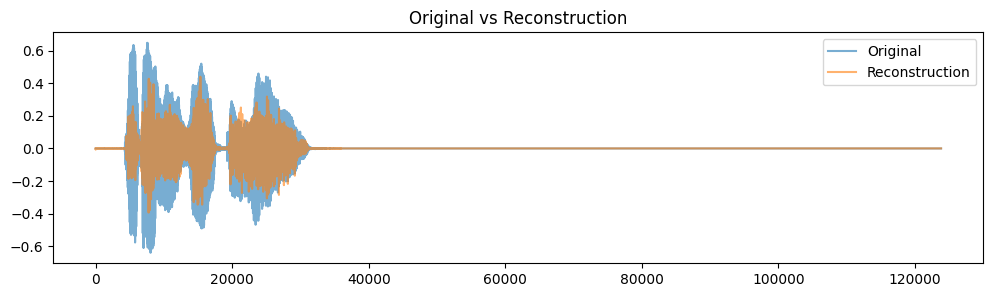

In [25]:
# Cell 11b — Reconstruction du fichier spécifique
import torchaudio
import torch.nn.functional as F
from IPython.display import Audio, display
import matplotlib.pyplot as plt

model.eval()

# 1) Charger et prétraiter l'audio cible
audio_path = "/content/DailyTalk/dailytalk/data/0/0_1_d0.wav"
wav, sr = torchaudio.load(audio_path)
if sr != SAMPLE_RATE:
    wav = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(wav)
audio = wav.mean(0)  # (L,)

# pad / truncate
if audio.size(0) > MAX_LENGTH:
    audio = audio[:MAX_LENGTH]
else:
    audio = F.pad(audio, (0, MAX_LENGTH - audio.size(0)))

# 2) Préparer la batch pour le modèle
input_tensor = audio.unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,L)

# 3) Inference
with torch.no_grad():
    # Remove return_dict=True
    outputs = model(input_tensor)
# 4) Récupérer la reconstruction
recon = outputs.audio_values.cpu().squeeze()  # (L,)
orig  = audio.cpu()

# 5) Afficher la MSE
mse = F.mse_loss(recon, orig).item()
print(f"MSE reconstruction vs original: {mse:.6f}")

# 6) Écouter l’original et la reconstruction
print("— Original —")
display(Audio(orig.numpy(), rate=SAMPLE_RATE))
print("— Reconstruction —")
display(Audio(recon.numpy(), rate=SAMPLE_RATE))

# 7) (Optionnel) Visualiser les deux formes d’onde
plt.figure(figsize=(12, 3))
plt.plot(orig.numpy(), alpha=0.6, label="Original")
plt.plot(recon.numpy(), alpha=0.6, label="Reconstruction")
plt.legend(loc="upper right")
plt.title("Original vs Reconstruction")
plt.show()

MSE reconstruction vs original: 0.003246
— Original —


— Reconstruction —


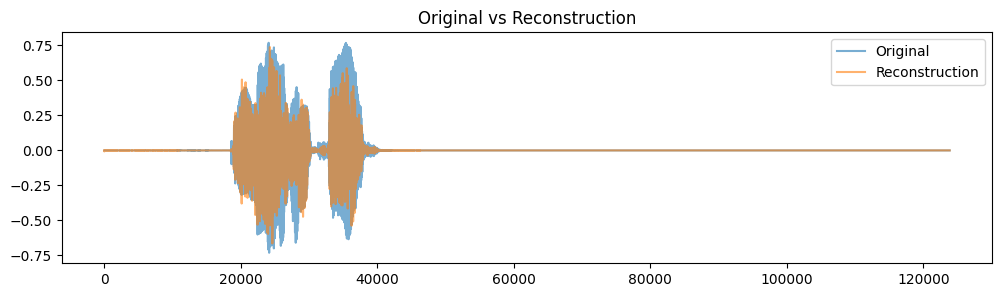

In [26]:
# Cell 11b — Reconstruction du fichier spécifique
import torchaudio
import torch.nn.functional as F
from IPython.display import Audio, display
import matplotlib.pyplot as plt

model.eval()

# 1) Charger et prétraiter l'audio cible
audio_path = "/content/DailyTalk/dailytalk/data/100/0_1_d100.wav"
wav, sr = torchaudio.load(audio_path)
if sr != SAMPLE_RATE:
    wav = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(wav)
audio = wav.mean(0)  # (L,)

# pad / truncate
if audio.size(0) > MAX_LENGTH:
    audio = audio[:MAX_LENGTH]
else:
    audio = F.pad(audio, (0, MAX_LENGTH - audio.size(0)))

# 2) Préparer la batch pour le modèle
input_tensor = audio.unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,L)

# 3) Inference
with torch.no_grad():
    # Remove return_dict=True
    outputs = model(input_tensor)
# 4) Récupérer la reconstruction
recon = outputs.audio_values.cpu().squeeze()  # (L,)
orig  = audio.cpu()

# 5) Afficher la MSE
mse = F.mse_loss(recon, orig).item()
print(f"MSE reconstruction vs original: {mse:.6f}")

# 6) Écouter l’original et la reconstruction
print("— Original —")
display(Audio(orig.numpy(), rate=SAMPLE_RATE))
print("— Reconstruction —")
display(Audio(recon.numpy(), rate=SAMPLE_RATE))

# 7) (Optionnel) Visualiser les deux formes d’onde
plt.figure(figsize=(12, 3))
plt.plot(orig.numpy(), alpha=0.6, label="Original")
plt.plot(recon.numpy(), alpha=0.6, label="Reconstruction")
plt.legend(loc="upper right")
plt.title("Original vs Reconstruction")
plt.show()

MSE reconstruction vs original: 0.000772
— Original —


— Reconstruction —


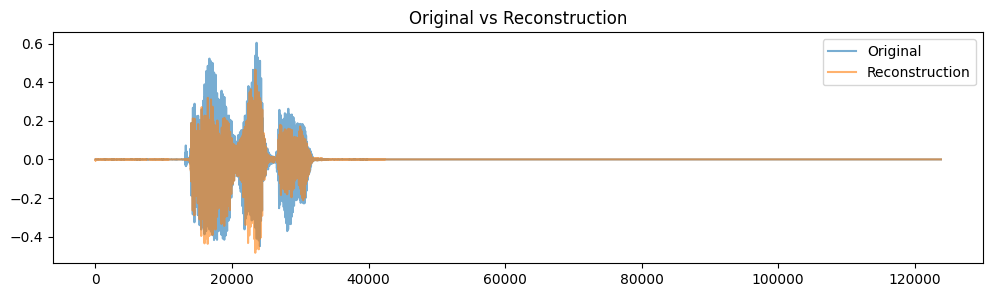

In [27]:
# Cell 11b — Reconstruction du fichier spécifique
import torchaudio
import torch.nn.functional as F
from IPython.display import Audio, display
import matplotlib.pyplot as plt

model.eval()

# 1) Charger et prétraiter l'audio cible
audio_path = "/content/DailyTalk/dailytalk/data/1006/0_0_d1006.wav"
wav, sr = torchaudio.load(audio_path)
if sr != SAMPLE_RATE:
    wav = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(wav)
audio = wav.mean(0)  # (L,)

# pad / truncate
if audio.size(0) > MAX_LENGTH:
    audio = audio[:MAX_LENGTH]
else:
    audio = F.pad(audio, (0, MAX_LENGTH - audio.size(0)))

# 2) Préparer la batch pour le modèle
input_tensor = audio.unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,L)

# 3) Inference
with torch.no_grad():
    # Remove return_dict=True
    outputs = model(input_tensor)
# 4) Récupérer la reconstruction
recon = outputs.audio_values.cpu().squeeze()  # (L,)
orig  = audio.cpu()

# 5) Afficher la MSE
mse = F.mse_loss(recon, orig).item()
print(f"MSE reconstruction vs original: {mse:.6f}")

# 6) Écouter l’original et la reconstruction
print("— Original —")
display(Audio(orig.numpy(), rate=SAMPLE_RATE))
print("— Reconstruction —")
display(Audio(recon.numpy(), rate=SAMPLE_RATE))

# 7) (Optionnel) Visualiser les deux formes d’onde
plt.figure(figsize=(12, 3))
plt.plot(orig.numpy(), alpha=0.6, label="Original")
plt.plot(recon.numpy(), alpha=0.6, label="Reconstruction")
plt.legend(loc="upper right")
plt.title("Original vs Reconstruction")
plt.show()

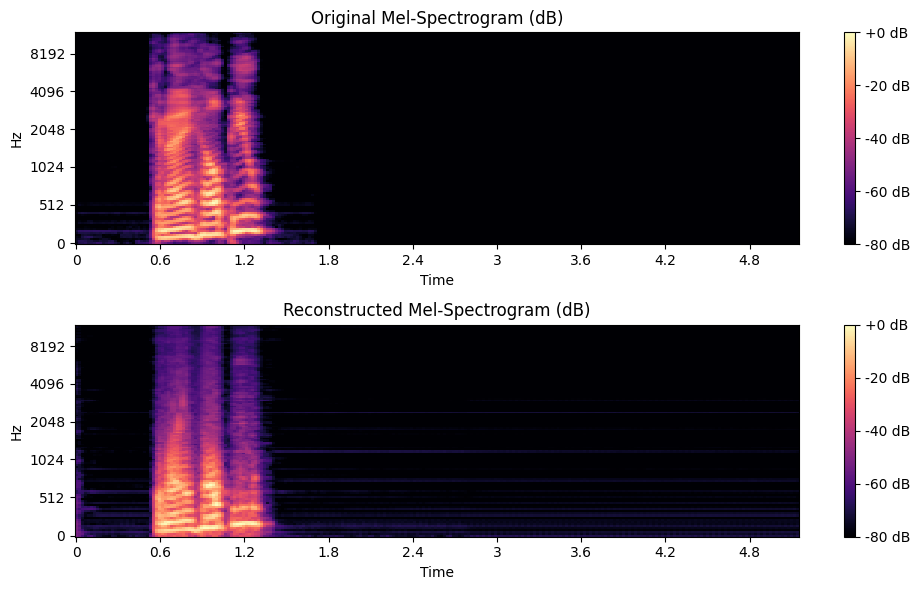

In [32]:
import librosa
import librosa.display
import numpy as np # Ensure numpy is imported for np.max
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# compute mel-spectrograms
S_orig = librosa.feature.melspectrogram(y=orig.numpy(), # Specify 'y' as the time series
                                        sr=SAMPLE_RATE,
                                        n_mels=128,
                                        fmax=SAMPLE_RATE//2)
S_recon = librosa.feature.melspectrogram(y=recon.numpy(), # Specify 'y' as the time series
                                         sr=SAMPLE_RATE,
                                         n_mels=128,
                                         fmax=SAMPLE_RATE//2)
# convert to log scale (dB)
log_S_orig  = librosa.power_to_db(S_orig, ref=np.max)
log_S_recon = librosa.power_to_db(S_recon, ref=np.max)

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
librosa.display.specshow(log_S_orig, sr=SAMPLE_RATE,
                         x_axis='time', y_axis='mel')
plt.title('Original Mel-Spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')
plt.subplot(2,1,2)
librosa.display.specshow(log_S_recon, sr=SAMPLE_RATE,
                         x_axis='time', y_axis='mel')
plt.title('Reconstructed Mel-Spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show() # Add plt.show() to display the plot

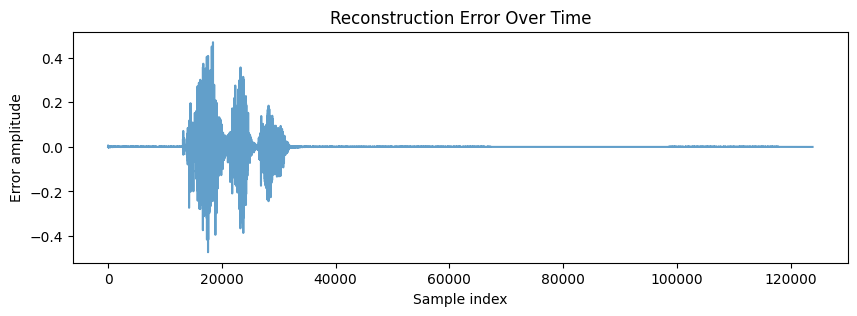

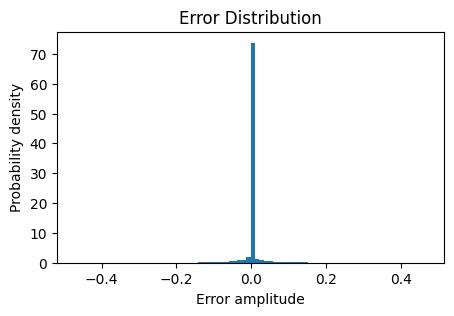

In [33]:
error = orig.numpy() - recon.numpy()
# waveform
plt.figure(figsize=(10,3))
plt.plot(error, alpha=0.7)
plt.title("Reconstruction Error Over Time")
plt.xlabel("Sample index")
plt.ylabel("Error amplitude")
plt.show()

# histogram
plt.figure(figsize=(5,3))
plt.hist(error, bins=80, density=True)
plt.title("Error Distribution")
plt.xlabel("Error amplitude")
plt.ylabel("Probability density")
plt.show()


In [30]:
# prompt: dowload this file : /content/encodec-dailytalk

files.download('/content/wandb')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# prompt: dowload this file zipped : /content/encodec-dailytalk

!zip -r /content/wandb /content/sample_data
files.download('/content/sample_data.zip')

  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/README.md (deflated 39%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/encodec-dailytalk/ (stored 0%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/ (stored 0%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/model.safetensors (deflated 7%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/scaler.pt (deflated 60%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/rng_state.pth (deflated 25%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/optimizer.pt (deflated 7%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/config.json (deflated 52%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/scheduler.pt (deflated 56%)
  adding: content/sample_data/encodec-dailytalk/checkpoint-3000/trainer_state.json (deflated 76%)
  adding: content/sample_data/encodec-dailytalk/checkpo

FileNotFoundError: Cannot find file: /content/sample_data.zip

In [35]:
processor.save_pretrained("/content/processor")

['/content/processor/preprocessor_config.json']